## **Project Title**: Predicting German Inflation using a simple ARIMA model

#### **Project Description**
##### *In this notebook, we predict German inflation rate using a simple ARIMA model. ARIMA stands for Auroregressive Intergrated moving average which is a Univariate forecasting model. The inflation rate is proxied by the Harmonised Index of Consumer Prices (HICP)(percentage change) from January 1996 to May 2024.* 

##### *More information regarding arima models can be obtained from* <a href= "https://people.duke.edu/~rnau/411home.htm">Click here</a>

##### *Inflation is the general increase in the overall price level of goods and services bought by households (citizens). It is measured as the average price change over a given period of time for a basket of goods and services that are purchased in the economy. In the euro area, it is measured as changes in the Harmonised Index of Consumer Prices (HICP) compared with the same period one year earlier (“year-on-year” changes). The HICP is broken down following the European classification of individual consumption according to purpose (ECOICOP) and by goods and services aggregates derived from it.*

##### *The link to the time series dataset can be found under* <a href= "https://data.ecb.europa.eu/data/datasets/ICP/ICP.M.DE.N.000000.4.ANR">Click here</a>




##### *We begin by importing all the python libraries used for this exercise.  The main library used for exploring the data and plots is pandas. Statsmodels library will be used for the econometric/statistical modelling*

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")



##### *The data is imported, cleaned and explored*

In [2]:
df = pd.read_csv('HICP_Ger.csv', sep='\\s+|,')
df.head()

,"""DATE","""""TIME","PERIOD""""","""""HICP",""""""""
0,"""1996-01-31","""""1996Jan""""","""""0.5""""""",NaN,NaN
1,"""1996-02-29","""""1996Feb""""","""""0.7""""""",NaN,NaN
2,"""1996-03-31","""""1996Mar""""","""""0.8""""""",NaN,NaN
3,"""1996-04-30","""""1996Apr""""","""""0.5""""""",NaN,NaN
4,"""1996-05-31","""""1996May""""","""""0.7""""""",NaN,NaN


In [3]:
columns_to_drop = [1, 3, 4]
df.drop(df.columns[columns_to_drop], axis=1, inplace=True)
        

In [4]:
df.columns = df.columns.str.replace('"', '')
df.head()

,DATE,PERIOD
0,"""1996-01-31","""""0.5"""""""
1,"""1996-02-29","""""0.7"""""""
2,"""1996-03-31","""""0.8"""""""
3,"""1996-04-30","""""0.5"""""""
4,"""1996-05-31","""""0.7"""""""


In [5]:
df.rename(columns = {"PERIOD":"HICP"}, inplace = True)

In [6]:
for cols in df:
    df[cols] = df[cols].str.strip('"')

df.head()

,DATE,HICP
0,1996-01-31,0.5
1,1996-02-29,0.7
2,1996-03-31,0.8
3,1996-04-30,0.5
4,1996-05-31,0.7




##### *Next, the dataset is converted so that pandas can recognize data as time series. The dates are indexed as timestamps specified in monthly frequency*

In [7]:
df.set_index("DATE", inplace = True)

In [8]:

df.index = pd.to_datetime(df.index)


In [9]:
df.index.freq = "M"
df.index

DatetimeIndex(['1996-01-31', '1996-02-29', '1996-03-31', '1996-04-30',
               '1996-05-31', '1996-06-30', '1996-07-31', '1996-08-31',
               '1996-09-30', '1996-10-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', name='DATE', length=341, freq='M')

In [10]:
df['HICP'] = pd.to_numeric(df['HICP'])


##### *Data (series) is plotted to visualize the behaviour/pattern. From the below plot, we do not have strong evidence of seasonality in the series. Moreover, the series looks pretty stable except for periods after 2019*

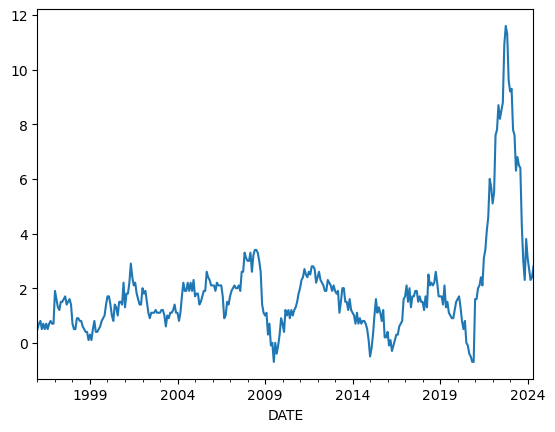

In [11]:
df['HICP'].plot();



##### *To verify the claim of non-seasonality, we decompose the series further using ETS Decomposition. ETS stands for Error-Trend-Seasonality method used specifically for time series decompositon*


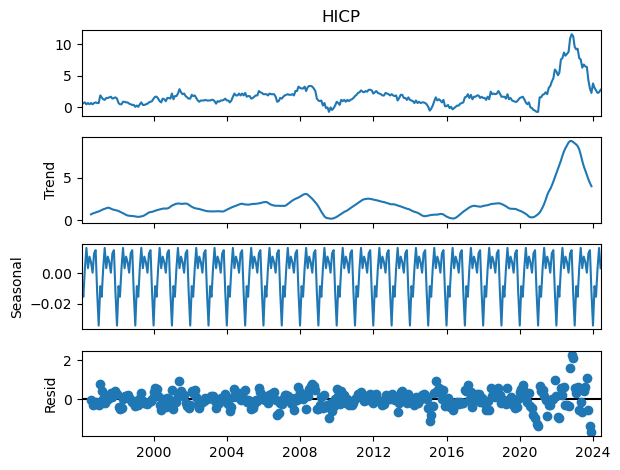

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df['HICP'], model='additive')  
decomp.plot();

##### *From the above plots, it can be observed that the magnitude of the seasonal swings (third row plot) is rather low - ranging between zero and negative 2. Hence it confirms the assertion regarding lack of evidence of seasonality in the data*


### Checking for stationarity
##### *Augmented Dickey fuller test and the Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test are used to check if the series is stationary. Of course from the above plot, it can be noticed that series appears not to have a constant mean and hence, likely to be non-stationary. Nevertheless a formal econometric test is conducted to confirm stationarity. The below function implements the test*.

#### Augmented dickey fuller (ADF) test

In [13]:

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
adf_test(df["HICP"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.270448
p-value                   0.016252
# lags used              14.000000
# observations          326.000000
critical value (1%)      -3.450569
critical value (5%)      -2.870447
critical value (10%)     -2.571515
Reject the null hypothesis
Data has no unit root and is stationary


##### *The outcome of ADF test indicates that the series is stationary. Due to the fact the the plot of the series does not clearly show stationarity, we employ the KPSS test to double check stationarity (an alternative stationarity test)*

####  Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test

In [15]:


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    if kpsstest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has  unit root and is therefore non-stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has no unit root and is stationary")

In [16]:
kpss_test(df["HICP"])

Results of KPSS Test:
Test Statistic            0.597286
p-value                   0.022883
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Reject the null hypothesis
Data has  unit root and is therefore non-stationary


##### *Above results from the KPSS indicates that the series is non-stationary. This has satisfied our curiosity since the actual plot does not point toward the direction of a stationary series.*

##### *Next, the difference of the series is computed and stationarity is tested in the below. The results below confirms stiationariy of the first difference of the series. Since the series is differenced only once to attain stationarity, the intergratedness of the ARIMA model is considered to be 1*

In [17]:
df["HICP_diff"] = diff(df["HICP"], k_diff=1)

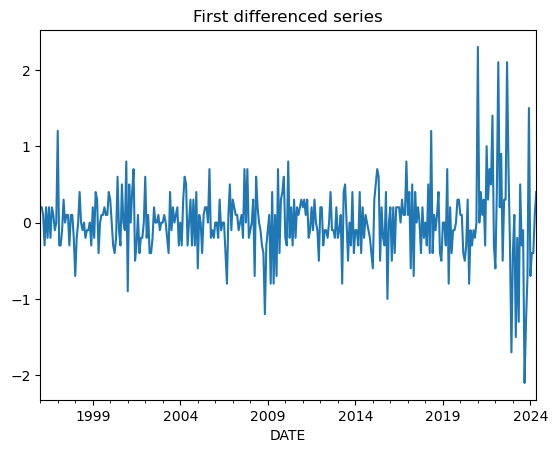

In [18]:
df["HICP_diff"].plot(title = "First differenced series");

In [19]:
df["HICP_diff"]

DATE
1996-01-31    NaN
1996-02-29    0.2
1996-03-31    0.1
1996-04-30   -0.3
1996-05-31    0.2
             ... 
2024-01-31   -0.7
2024-02-29   -0.4
2024-03-31   -0.4
2024-04-30    0.1
2024-05-31    0.4
Freq: M, Name: HICP_diff, Length: 341, dtype: float64

##### *Above differenced plot appears to be stable and exhibits a constant mean hovering around zero. Nevertheless it appears the variability in the last section of the data (from 2019) is greater than the earlier part of the data - due to COVID-effects etc.*


##### *Next, the KPSS test for the diffirenced data is diplayed below. This test is computed just to ensure the series is integrated of order 1 (I(1)) - implying stationarity at first difference*

In [20]:
kpss_test(df["HICP_diff"][1:])

Results of KPSS Test:
Test Statistic           0.037781
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Fail to reject the null hypothesis
Data has no unit root and is stationary




### Selecting the ARIMA model
##### *To proceed with modelling, it is important to ascertain the lags length for the AR and MA components of the ARIMA model. The Auto_arima from the pmdarima library is used for the selection of the optimal lags. Alternatively one can use a manual process by visualizing the ACF and PACF plots. However, the interpretation of the ploty can sometimes be far from straightfoward.  In this exercise, we will firstly use the automatic process (auto_arima) to select the optimal ARIMA model. Subsequently, the ACF and PACF plots will be examined manually*


In [21]:
auto_arima(df["HICP"],  trace=True,stepwise=True, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=448.100, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=455.229, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=457.147, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=457.164, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=453.300, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=446.564, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=454.004, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=452.488, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=448.003, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=449.548, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=449.974, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=444.633, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=452.066, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=450.569, 

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##### *ARIMA(1,1,2) is chosen as the optimal model since it has the minimum information criteria values (AIC)*

##### *As already mentioned, one can look at the PACF and ACF plots to manually choose the best ARIMA model. In what follows below, we will look at each plot*

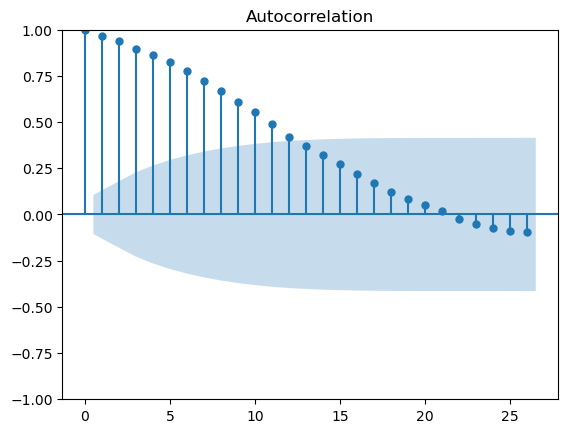

In [22]:
plot_acf(df["HICP"]);

##### *The above auto correlation plot indicate slow decaying of the lag lenghts. Note that the acf plots is used to determined the number of lags for the moving average part of the ARIMA. From the above plot, the suitable choice for the MA part is roughly 12 since the plot shows a cut-off from 12 lags.*

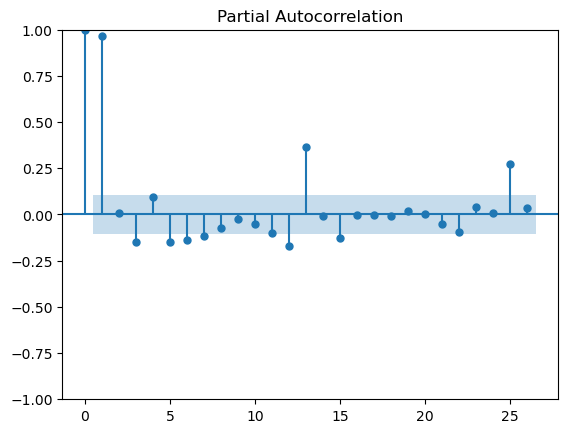

In [23]:
plot_pacf(df["HICP"]);

##### *The above  plot shows that the pacf cuts off after the first lag (since is out of the significance zone). Hence an AR-1 is appropraite for the ARIMA. Of course there are few lags which are out of the bounds but that is not problematic since those lags do not follow in a chronological order. In conclusion, ARIMA(1,1,12) is preferred if we follow the reulst from the ACF and PACF plot.*

##### *In what follows next, we will consider both models.  The idea is to compare the predictions/performance of the two models*

##### *i. ARIMA(1,1,2) - results from the automatic lag selection*  
##### *ii. ARIMA(1,1, 12)) - results from manual lag selection.*


### The ARIMA Model
##### *To build a model suitable for predicting into the future, we firstly divide the data into train and test sets. The trained data would be used for building the model and test data used for the purposes of predicting. For the test data, we use the last 12 months since the idea is to predict inflation for the next year (12 months).*


#### **Train-test split**
##### The train set consist of the first 329 months, whilst the test set consist of the last 12 months of the data

In [27]:
 df_train = df.iloc[:329]
 df_test  = df.iloc[329:]

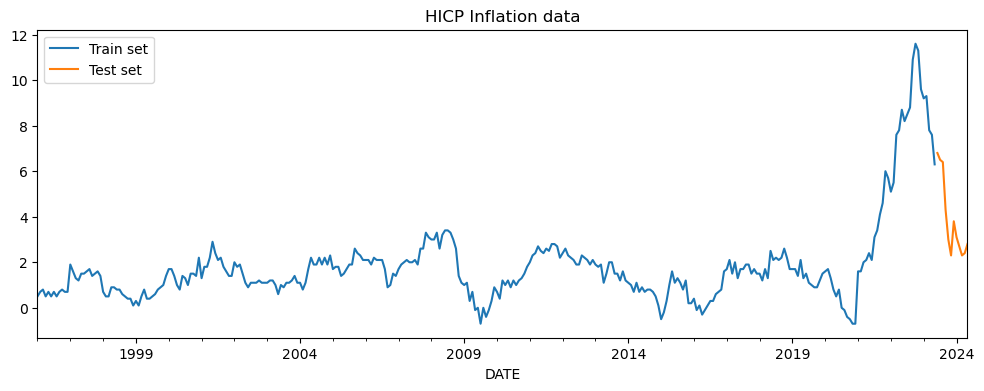

In [28]:
df_train["HICP"].plot(legend = True, label = "Train set",figsize=(12,4))
df_test["HICP"].plot(legend = True, label = "Test set", title = "HICP Inflation data");


#### ARIMA(1,1,2)
##### Firstly, the ARIMA(1,1,2) model is fitted

In [29]:
arima_mod = ARIMA(df_train["HICP"], order=(1,1,2)).fit()

In [30]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   HICP   No. Observations:                  329
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -193.983
Date:                Wed, 12 Jun 2024   AIC                            395.965
Time:                        22:37:24   BIC                            411.137
Sample:                    01-31-1996   HQIC                           402.018
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6505      0.153     -4.248      0.000      -0.951      -0.350
ma.L1          0.6344      0.140      4.521      0.000       0.359       0.909
ma.L2          0.1361      0.060      2.283      0.022       0.019       0.253
sigma2         0.1910      0.008     22.817      0.000       0.175       0.207
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               423.57
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


##### *The trained model is used on the test data (unseen data) to make prediction for the last 12 months. After that the inflation (HICP) for the last 12 months is compared to the predicted data to see how close the two series are (model evaluation).*

In [31]:
start = len(df_train)
end = len(df_train)+ len(df_test) - 1

In [32]:
arima_test_pred = arima_mod.predict(start=start, end=end, typ="levels").rename("ARIMA (1,1,2) Prediction")

#### ARIMA(1,1,12)
##### *Next the ARIMA(1,1,12) is also fitted after which the two models are compared*

In [34]:
arima_mod_12 = ARIMA(df_train["HICP"], order=(1,1,12)).fit()
arima_test_pred_12 = arima_mod_12.predict(start=start, end=end, typ="levels").rename("ARIMA (1,1,12) Prediction")



##### *Actual HICP(test data) is compared against ARIMA predicted HICP*

In [35]:
 pd.concat([df_test["HICP"].rename("Actual"), 
            round(arima_test_pred.rename("Predicted-ARIMA(1,1,2)"),2),
           round(arima_test_pred_12.rename("Predicted-ARIMA(1,1, 12)"),2)], axis = 1)

,Actual,"Predicted-ARIMA(1,1,2)","Predicted-ARIMA(1,1, 12)"
2023-06-30,6.8,6.43,6.44
2023-07-31,6.5,6.20,6.40
2023-08-31,6.4,6.35,6.17
2023-09-30,4.3,6.25,5.02
2023-10-31,3.0,6.32,4.37
2023-11-30,2.3,6.27,4.08
2023-12-31,3.8,6.30,5.14
2024-01-31,3.1,6.28,5.12
2024-02-29,2.7,6.30,4.92
2024-03-31,2.3,6.29,5.35


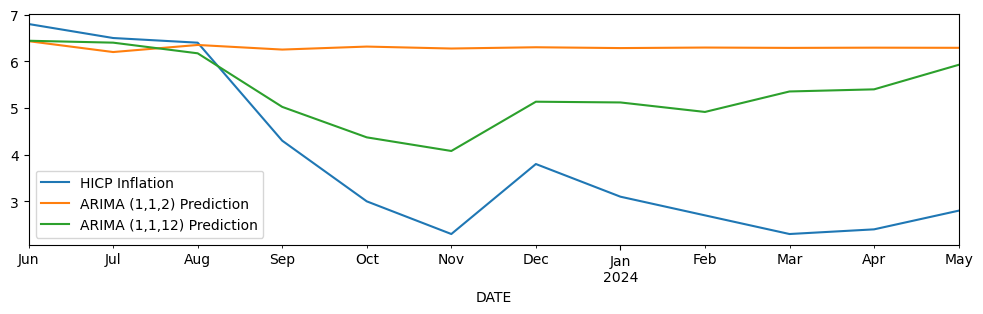

In [36]:
df_test["HICP"].plot(legend=True, label = "HICP Inflation",figsize=(12,3));
arima_test_pred.plot(legend=True);
arima_test_pred_12.plot(legend=True);

##### *From the above graph, it can be observed that the ARIMA(1,1,12) does a better job of tracking the actual HICP  quite well as compared to  the ARIMA(1,1,2). Also it can be noticed that three series are closest in the first three months, after which the the difference between them gets wider. Our prediction is most effective in the initial three months*


#### Model evaluation 
##### *Regarding the model evaluation, the mean square error and root mean square errors are computed using the test data. In order words we would like to evaluate the models based on the unseen test data*

In [37]:

arima_mse = mean_squared_error(df_test["HICP"],arima_test_pred)
arima_rmse = rmse(df_test["HICP"],arima_test_pred)

arima_mse_12 = mean_squared_error(df_test["HICP"],arima_test_pred_12)
arima_rmse_12 = rmse(df_test["HICP"],arima_test_pred_12)

print(f"The MSE for ARIMA(1,1,1) is {arima_mse:.3f}")
print(f"The RMSE for ARIMA(1,1,1) is {arima_rmse:.3f}")

print("")

print(f"The MSE for ARIMA(1,1,12) is {arima_mse_12:.3f}")
print(f"The RMSE for ARIMA(1,1,12) is {arima_rmse_12:.3f}")

The MSE for ARIMA(1,1,1) is 8.618
The RMSE for ARIMA(1,1,1) is 2.936

The MSE for ARIMA(1,1,12) is 3.719
The RMSE for ARIMA(1,1,12) is 1.929


##### It can be observed ARIMA(1,1,12) is superior of the two models since it has the minimal MSE and RMSE


#### Prediction into the future

##### *Next we used both models to train the full data and then predict 12 months into the future. In this case we do not have any test data to ccompare our results with. We will build a model with the full dataset and then predict into the future*


##### *We will start by training the model with ARIMA(1,1,2)*


In [38]:
full_arima_train = ARIMA(df["HICP"], order=(1,1,2)).fit()

In [39]:
print(full_arima_train.summary())

                               SARIMAX Results                                
Dep. Variable:                   HICP   No. Observations:                  341
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -218.316
Date:                Wed, 12 Jun 2024   AIC                            444.633
Time:                        22:37:31   BIC                            459.949
Sample:                    01-31-1996   HQIC                           450.735
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7206      0.099     -7.271      0.000      -0.915      -0.526
ma.L1          0.7459      0.104      7.141      0.000       0.541       0.951
ma.L2          0.1670      0.055      3.060      0.0

##### *Next, we visualize the residuals*


#### The Residuals of the ARIMA(1,1,2) model is visualized

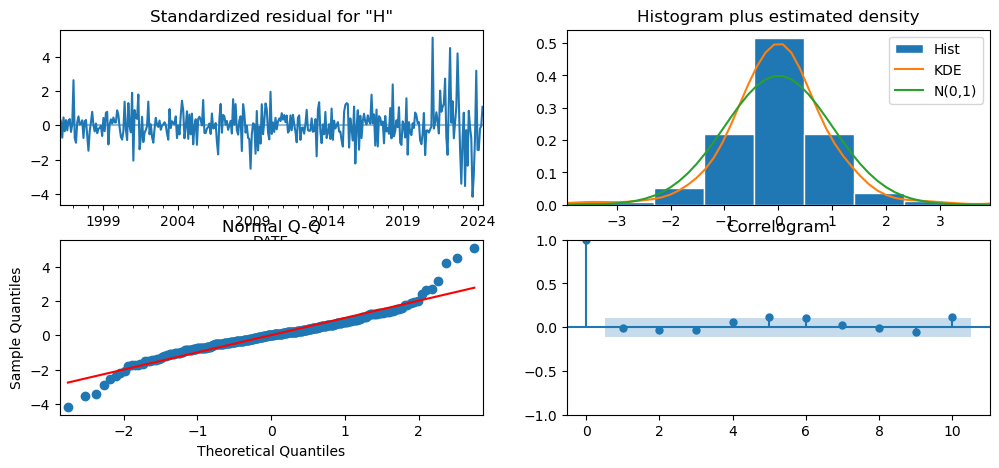

In [40]:
full_arima_train.plot_diagnostics(figsize=(12, 5));

#### Comments on the residual diagnostics for ARIMA(1,1,2) as follows:

##### *1. Beginning from the top right hand corner, it can be noticed that the standardized residuals are stationary. The residuals can be said to follow i.i.d sequence with a zero mean. There are few outliers with few exceeding standard deviation of 3.*

##### *2. Top right hand corner indicates that the residuals are Gaussian (normally distributed or marginally normal).*

##### *3. The buttom left shows a plot of the theoritical quantile against the empirical quantile (Q-Q plot) - confirming once again that residuals are pretty normal.*

##### *4. The correlogram on the buttom right shows the lack of evidence of autocorrelation in the residuals (randomness of the residuals synonimous to a white noise process). The above residual diagnostics are pretty good*  






#### ARIMA (1,1,2) forecast
##### *Next, we proceed to make predictions/forecast using our fitted ARIMA(1,1,2) model*


In [41]:
full_arima_pred = full_arima_train.predict(start=len(df), end=len(df)+11, typ='levels').rename("ARIMA(1,1,2) Prediction")

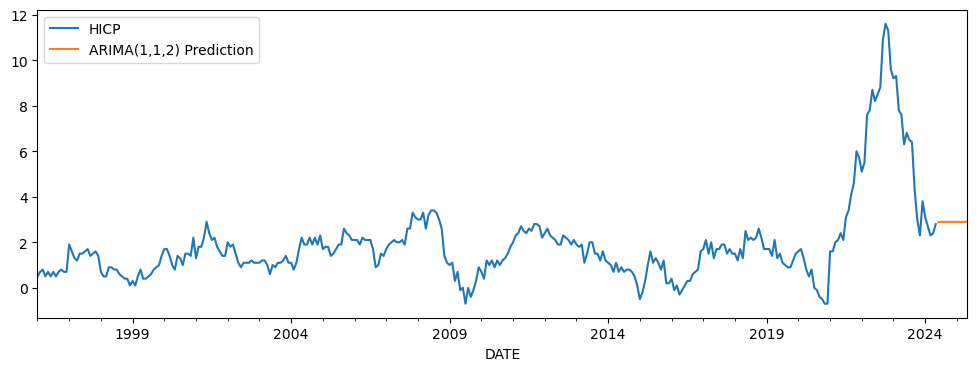

In [42]:
df["HICP"].plot(legend=True, figsize=(12,4));
full_arima_pred.plot(legend=True);

#### ARIMA (1,1,12) forecast
##### *Similarly, we proceed to make predictions/forecast using our fitted ARIMA(1,1,12) model*

In [43]:
full_arima_train_12 = ARIMA(df["HICP"], order=(1,1,12)).fit()
full_arima_predict_12 = full_arima_train_12.predict(start=len(df), end=len(df)+11, typ="level").rename("ARIMA (1,1,12) Prediction")

#### ARIMA(1,1,12) Residual diagnostics for the trained model

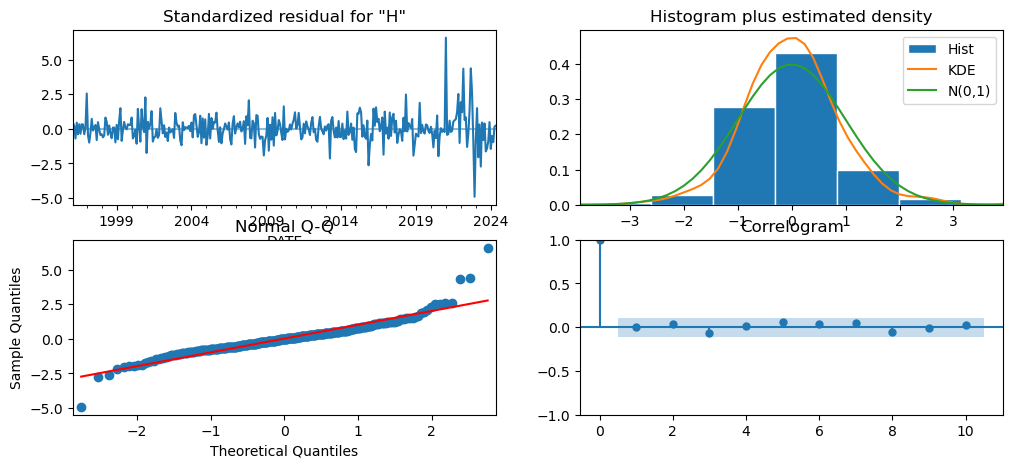

In [44]:
full_arima_train_12.plot_diagnostics(figsize=(12, 5));

##### *It can be observed from the above residual diagnostics that the residuals appears to follow a white noise stationary process. The Q-Q plots also shows residuals follows a normal distribution (also the density plot) and finally correlogram displays the absence of serial correlation.*

##### *In the below, the actual plot including the forecasted values is displayed*

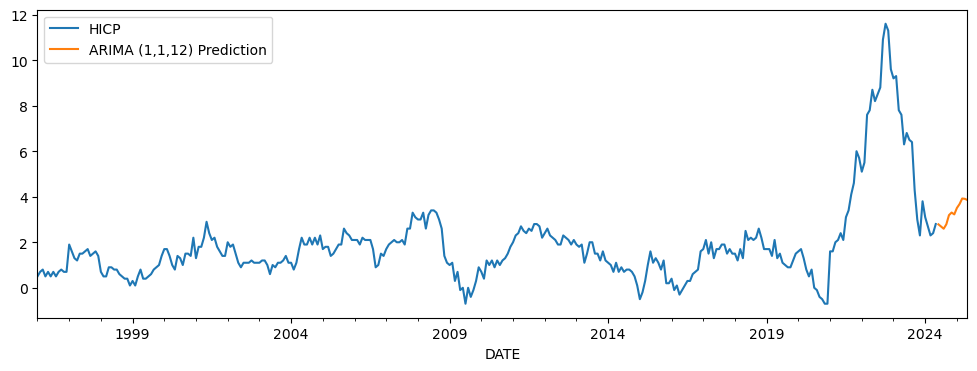

In [45]:
df["HICP"].plot(legend=True, figsize=(12,4));
full_arima_predict_12.plot(legend=True);

#### Comparing future forecasted values for the two model predictions: ARIMA(1,1,2) versus ARIMA(1,1,12)

In [46]:
print("Inflation forecast for the next 12 months:")
pd.concat([full_arima_pred,full_arima_predict_12], axis=1)

Inflation forecast for the next 12 months:


,"ARIMA(1,1,2) Prediction","ARIMA (1,1,12) Prediction"
2024-06-30,2.879884,2.787308
2024-07-31,2.905231,2.691597
2024-08-31,2.886966,2.594463
2024-09-30,2.900128,2.788559
2024-10-31,2.890643,3.191442
2024-11-30,2.897478,3.305798
2024-12-31,2.892553,3.222994
2025-01-31,2.896102,3.506458
2025-02-28,2.893544,3.677159
2025-03-31,2.895388,3.922247


##### The above depicts the values for the two model predictions. On average the ARIMA(1,1,12) values are slightly higher

##### *Thats all for now, thank you :)*